# Sprint12課題 深層学習スクラッチ畳み込みニューラルネットワーク1



## この課題の目的
スクラッチを通してCNNの基礎を理解する。

## 2.スクラッチによる実装

NumPyなど最低限のライブラリのみを使いアルゴリズムを実装する。

Sprint11で作成したディープニューラルネットワークのクラスを拡張する形でCNNを作成する。

まず、Sprint12で1次元畳み込み層を作成し、畳み込みの基礎を理解することを目指す。

そして、Sprint13で一般的に画像に対して使われる2次元畳み込み層とプーリング層を作成する。

### 1次元畳み込み層

畳み込みニューラルネットワークは画像に対して使われる2次元畳み込みが代表的だが、理解を容易にするためにまずは1次元畳み込みを実装する。

1次元畳み込みは系列データで使われることが多い。

畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまでがフレームワークで一般的に用意されている。

### データセットの用意

引き続きMNISTデータセットを使用する。

1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力する。

### CNN分類器クラスの作成

1次元畳み込みニューラルネットワークモデルのクラスScratch1dCNNClassifierを作成する。

Sprint11で作成したScratchDeepNeuralNetrowkClassifierを元にすること。

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from keras.datasets import mnist

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成

チャンネル数を1に限定した1次元畳み込み層のクラス<font color="blue">**SimpleConv1d**</font>を作成する。

基本構造はsprint11で作成したFCクラスと同じになる。

なお、重みの初期化に関するクラスは必要に応じて作り変えること。

Xavierの初期値などを使う点は全結合層と同様。

ここではパディングは考えず、ストライドも1に固定する。

また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応する。

この部分の拡張はアドバンス課題とする。

フォワードプロパゲーションの数式は以下のようになる。

<style text-align:center>
$a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b$
</style>


- $a_i$ : 出力される配列のi番目の値

- $F$ : フィルタのサイズ

- $x(i+s)$: 入力の配列の$(i+s)$番目の値

- $w_s$ : 重みの配列のs番目の値

- $b$ : バイアス項

全てスカラーである。

次に更新式で、AdaGradなどに置き換えられる点は全結合層と同様である。

- $lr$ : 学習率

- $\frac{dL}{dws}$ :$ w_s$に関する損失 $L$の勾配

- $\frac{dL}{db}$ : $b$ に関する損失 $L$ の勾配

勾配 $\frac{dL}{dws}$や $\frac{dL}{db}$ を求めるためのバックプロパゲーションの数式は以下の通り。
 
- $\frac{\partial L}{\partial w_s} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}x_{(i+s)}$

- $\frac{\partial L}{\partial b} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}$

- $\frac{dL}{dai}$ : 勾配の配列のi番目の値

- $N_{out}$ : 出力のサイズ

前の層に流す誤差の数式は以下の通り。

- $\frac{\partial L}{\partial x_j} = \sum_{s=0}^{F-1} \frac{\partial L}{\partial a_{j-s}}w_s$


- $\frac{dL}{dxj}$ : 前の層に流す誤差の配列のj番目の値


ただし、$j$−$s$ < 0 または $j$−$s$>$N_{out}$ - 1 のとき $\frac{dL}{da_{(j - s)}}$=0 。

全結合層との大きな違いは、重みが複数の特徴量に対して共有されていること。

この場合は共有されている分の誤差を全て足すことで勾配を求める。

計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになる。

In [2]:
# データセット
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [0]:
# 検証用データの作成

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [0]:
import numpy as np

class SimpleConv1d:
    """
    チャンネル数を１に限定した１次元畳み込み層
    
    Parameters
    ----------
    b : 次の形のndarray, shape(m_samples, n_features)
        バイアス項
    
    lr : float
        学習率
    
    w : 次の形のndarray, shape(m_samples, n_features)
        フィルタ
    
    P : int
        パディング
    
    S : int
        ストライド
    
    Attributes
    ----------
    self.conv_index : 次の形のndarray, shape(N_out, F)
        積和演算に用いる入力のインデックス
    
    self.F : int
        フィルタサイズ
    
    self.N_out : int
        出力の数
    
    """
    
    def __init__(self, b, w, lr=1e-2, N_in=4, P=0, S=1):
        
        self.b = b
        self.lr = lr
        self.N_in = N_in
        self.P = P
        self.S = S
        self.w = w
        
        self.F = self.w.shape[0]
        self.N_out = self.calcOutputSize()
        self.conv_Z = self.create_index(self.N_in, self.N_out)
        
        self.Z = None
    
    
    def forward(self, Z):
        """
        フォワードプロパゲーション
        
        Parameters
        -----------
        Z : 次の形のndarray, shape(samples, features)
            入力
        
        Returns
        ----------
        N_out : 次の形のndarray, shape()
            出力
        """
        self.Z = Z
        self.conv_Z = Z[self.conv_Z]
        
        N_out = np.sum(self.conv_Z * self.w, axis=1) + self.b
        
        return N_out
    
    
    def backward(self, dA):
        """
        バックワードプロパゲーション
        
        Parameters
        ----------
        dA : 次の形のndarray,  shape(m_samples, n_features)
            後の層の損失の勾配
        
        Returns
        ----------
        
        """
        N_in = len(dA)
        N_out = len(self.Z)
        
        db = np.sum(dA) # バイアス
        dw = dA @ self.conv_Z # 重み
        
        # convolution用のインデックス
        conv_w = np.zeros(N_in * N_out).reshape(N_in,  N_out).astype(np.int)
        
        for i in range(N_in):
            conv_w[i][i: i+self.F:1] = self.w
        
        dx = dA @ conv_w
        
        return dx
        
    
    def calcOutputSize(self,):
        """
        1次元畳み込み後の出力サイズの計算

        Parameters
        ----------
        N_in : 次の形のndarray, shape(m_samples, n_features)
            入力のサイズ（特徴量の数）

        w : 次の形のndarray, shape(m_samples, n_features)
            フィルタ

        P : int
            ある方向へのパディングの数

        S : int
            ストライドのサイズ

        Returns
        ----------
        N_out : int
            出力のサイズ（特徴量の数）=> ノードの数

        """
        
        N_out = int((self.N_in + 2*self.P - self.F) / self.S + 1)

        return N_out
        
    
    def create_index(self, N_in, N_out):
        """
        Convolutionに用いるindexの配列を生成する

        Parameters
        ----------
        N_in : 次の形のndarray, shape(m_samples, n_features)
            入力のサイズ（特徴量の数）

        N_out : int
            出力のサイズ

        Returns
        ----------
        conv_index : 
            convolutionに用いるインデックスの配列
        """
        N_in_index = np.arange(N_in)

        # Convolutionに用いるインデックスの配列を生成する
        conv_index = np.zeros((N_out, self.F)).astype(np.int)
        
        for i in range(N_out):
            conv_index[i] = N_in_index[i : i + self.F : self.S]
            
        return conv_index

## 【問題2】1次元畳み込み後の出力サイズの計算
畳み込みを行うと特徴量の数が変化する。

どのように変化するかは以下の数式から求められる。（パディングやストライドも含めている）

この計算を行う関数を作成すること。

$N_{out} = \frac{N_{in}+2P-F}{S} + 1$

$N_{out}$ : 出力のサイズ（特徴量の数）

$N_{in}$ : 入力のサイズ（特徴量の数）

$P$ : ある方向へのパディングの数

$F$ : フィルタのサイズ

$S$ : ストライドのサイズ

In [0]:
import numpy as np

def calcOutputSize(N_in, w, P, S):
    """
    1次元畳み込み後の出力サイズの計算
    
    Parameters
    ----------
    N_in : 次の形のndarray, shape(m_samples, n_features)
        入力のサイズ（特徴量の数）
    
    w : 次の形のndarray, shape(m_samples, n_features)
        フィルタ
    
    P : int
        ある方向へのパディングの数
        
    S : int
        ストライドのサイズ
    
    Returns
    ----------
    N_out : int
        出力のサイズ（特徴量の数）=> ノードの数
    
    """
    # フィルタサイズ
    F = w.shape[0]
    
    # 出力のサイズ
    N_out = int((N_in + 2*P - F) / S + 1)

    return N_out

## 【問題3】小さな配列での1次元畳み込み層の実験

In [0]:
# サンプル
x = np.array([1,2,3,4])
w = np.array([3,5,7])
b = np.array([1])
y = np.array([45, 70])

In [0]:
# 分類器の生成
clf = SimpleConv1d(b, w)

In [9]:
pred = clf.forward(x)
pred

array([35, 50])

In [10]:
delta_a = y - pred
delta_a

array([10, 20])

In [11]:
clf.backward(delta_a)

array([ 30, 110, 170, 140])

- 正しい結果が得られていることを確認できた。

## 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成

チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成する。

計算グラフを書いた上で、バックプロパゲーションも手計算で考える。
（計算グラフの中には和と積しか登場しないので、微分を新たに考える必要はない。）

<補足>

チャンネル数を加える場合、配列をどういう順番にするかという問題がある。

(バッチサイズ、チャンネル数、特徴量数)または(バッチサイズ、特徴量数、チャンネル数)が一般的で、ライブラリによって順番は異なる。

今回のスクラッチでは自身の実装上どちらが効率的かを考えて選ぶこと。

上記の例ではバッチサイズは考えておらず、(チャンネル数、特徴量数)である。

In [0]:
import numpy as np

class Conv1d:
    """
    チャンネル数を限定しない１次元畳み込み層
    
    Parameters
    ----------
    b : 次の形のndarray, shape(m_samples, n_features)
        バイアス項
    
    lr : float
        学習率
    
    w : 次の形のndarray, shape(n_out, n_in, channls)
        フィルタ
    
    P : int
        パディング
    
    S : int
        ストライド
    
    Attributes
    ----------
    self.conv_index : 次の形のndarray, shape(N_out, F)
        積和演算に用いる入力のインデックス
    
    self.F : int
        フィルタサイズ
    
    self.N_out : int
        出力の数
                
    self.dw : 次の形のndarray, shape(n_out, n_in, channels)
        重みに流す勾配
        
    self.db : 次の形のndarray, shape(features)
        バイアスに流す勾配
    
    """
    
    def __init__(self, b, w, lr=1e-2, N_in=4, P=0, S=1):
        
        self.b = b
        self.lr = lr
        self.N_in = N_in
        self.P = P
        self.S = S
        self.w = w
        self.b = b
        
        self.F = self.w.shape[0]
        self.N_out = self.calcOutputSize()
        self.out = None
        
        self.dw = np.zeros((self.w.shape))
        self.db = np.zeros(self.b.size)
        self.dz = None
        
        self.Z = None
    
    
    def forward(self, Z):
        """
        フォワードプロパゲーション
        
        Parameters
        -----------
        Z : 次の形のndarray, shape(samples, channels, features)
            特徴量
        
        Returns
        ----------
        self.out : 次の形のndarray, shape(samples, channels, features)
            出力
        """
        # 入力値の次元数が２（＝サンプル数が１）の場合、軸を追加する
        if Z.ndim == 2:
            Z = Z[np.newaxis, :, :]
        
        self.Z = Z

        N_in = Z.shape[2]
        N_out = int((N_in + 2*self.P - self.F) / self.S + 1)
                
        # 出力を初期化(samples, N_out, features)
        self.out = np.zeros((Z.shape[0], self.w.shape[0], N_out))
        
        for n in range(Z.shape[0]):
            for i in range(self.w.shape[0]):
                for j in range(N_out):                
                    self.out[n, i, j] = np.sum(Z[n, : , j: j+self.w.shape[2]] * self.w[i])
            self.out[n] += self.b[:, np.newaxis]
        
        return self.out
    
    
    def backward(self, dA):
        """
        バックワードプロパゲーション
        
        Parameters
        ----------
        dA : 次の形のndarray,  shape(m_samples, n_features)
            後の層の損失の勾配
        
        Returns
        ----------
        self.dz : 次の形のndarray, shape(m_samples, n_features)
            前の層に流す勾配
        """
        # フィルタ（出力チャネル数、入力チャネル数、特徴量）
        N_out, N_in, N_features = self.w.shape
        
        # バイアスに流す勾配
        self.db = np.sum(dA, axis=0).mean(axis=1) # バッチサイズ方向に合計、特徴量方向に平均
                
        # 重みに流す勾配（０で初期化）
        self.dw = np.zeros(self.w.shape)
        
        # 深さ方向(axis=0)に合計
        for n in range(dA.shape[0]): #0
            for row in range(dA.shape[1]): #0, 1, 2
                for column in range(dA.shape[2]): # 0, 1
                    self.dw[row] += dA[n][row][column] * self.Z[n, :, column:column+N_features]
        
        # 前の層に流す勾配
        self.dz = np.zeros(self.Z.shape)

        
        for n in range(dA.shape[0]):
            for row in range(dA.shape[1]):
                for column in range(dA.shape[2]):
                    self.dz[n, : , column : column+N_features] += dA[n][row][column] * self.w[row]
        
        return self.dz
        
        
    def calcOutputSize(self,):
        """
        1次元畳み込み後の出力サイズの計算
 
        Parameters
        ----------
        N_in : 次の形のndarray, shape(m_samples, n_features)
            入力のサイズ（特徴量の数）

        w : 次の形のndarray, shape(m_samples, n_features)
            フィルタ

        P : int
            パディング数

        S : int
            ストライドサイズ

        Returns
        ----------
        N_out : int
            出力のサイズ（特徴量）

        """
        
        N_out = int((self.N_in + 2*self.P - self.F) / self.S + 1)
        
        return N_out

### 検証

- x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
- w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
- b = np.array([1, 2, 3]) # （出力チャンネル数）

出力は、a = np.array([[16, 22], [17, 23], [18, 24]]) # shape(3, 2)で（出力チャンネル数、特徴量数）である。

In [0]:
# 前提条件、正解例
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

y = np.array([17, 23, 18, 24, 19, 25]).reshape(3,2)

In [0]:
sample = np.arange(6).reshape(1,3,2)
b = np.arange(3)

In [15]:
sample[0] + b[:, np.newaxis]

array([[0, 1],
       [3, 4],
       [6, 7]])

In [0]:
clf = Conv1d(b, w)

#### フォワードプロパゲーションの検証

In [17]:
a = clf.forward(x)
a

array([[[15., 21.],
        [16., 22.],
        [17., 23.]]])

- フォワードプロパゲーションについては、正しい結果が得られていることを確認できた。

#### バックプロパゲーションの検証

In [18]:
dA = np.arange(6).reshape(1,3,2)
dA

array([[[0, 1],
        [2, 3],
        [4, 5]]])

In [19]:
clf.backward(dA)

array([[[ 6., 15., 15.,  9.],
        [ 6., 15., 15.,  9.]]])

- バックプロパゲーションも機能していることを確認した。

## 【問題5】学習・推定

これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えて学習と推定を行うこと。

出力層だけは全結合層をそのまま使う。

チャンネルが複数ある状態では全結合層への入力は行えないため、その段階でのチャンネルは1になるようにするか、平滑化を行う。

平滑化はNumPyのreshapeを用いる。

[numpy.reshape — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.reshape.html)

画像に対しての1次元畳み込みは実用上は行わないため、精度は問わない。

In [0]:
# 演算処理
import numpy as np

# 可視化
import matplotlib.pyplot as plt

# 機械学習
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

# プログレスバー
from tqdm import tqdm_notebook as tqdm

class ScratchDeepNeuralNetworkClassifier:
    """
    ディープニューラルネットワークのスクラッチ実装
    
    Parameters
    ----------
    activation : str
        活性化関数の種類
    
    batch_size : int
        ミニバッチのサイズ
    
    epoch : int
        エポック数
    
    initializer : str
        パラメータ初期値を生成するクラス
    
    lr : float
        学習率
        
    n_nodes1 : int
        １層目のレイヤー数
        
    n_nodes2 : int
        2層目のレイヤー数
    
    n_output : int
        出力数
    
    optimizer : str
        最適化手法
    
    random_state_batch : int
        ミニバッチ生成時の乱数のシード値
    
    random_state_para : int
        パラメータ初期値生成時の乱数のシード値
    
    sigma : float
        SimpleInitializerの標準偏差
    
    verbose : bool
        学習過程の出力
    
    Attributes
    ----------
    self.train_loss : list
        学習用データに基づく交差エントロピー損失
    
    self.val_loss : list
        検証用データに基づく交差エントロピー損失
    
    self.y_pred : 次の形のndarray, shape(batch_size)
        予測値
    """
    
    def __init__(self, activation="Tanh", batch=30, initializer="Simple", n_epochs = 10, lr=1e-2, n_nodes1=400, n_nodes2=200, optimizer="SGD", sigma=0.01, verbose=False):
        
        # パラメータ
        self.activation = activation
        self.batch = batch
        self.initializer = initializer
        self.lr = lr
        self.n_epochs = n_epochs
        self.features = 2346 # (フィルタサイズ：3 × 出力サイズ：782)
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = 10
        self.optimizer = optimizer
        self.sigma = sigma
        self.verbose = verbose
        
        
        # パラメータ初期値
        if self.initializer == "Simple":
            initializer1 = SimpleInitializer(self.sigma)
            initializer2 = SimpleInitializer(self.sigma)
            initializer3 = SimpleInitializer(self.sigma)
        elif self.initializer == "Xavier":
            initializer1 = XavierInitializer()
            initializer2 = XavierInitializer()
            initializer3 = XavierInitializer()
        elif self.initializer == "He":
            initializer1 = HeInitializer()
            initializer2 = HeInitializer()
            initializer3 = HeInitializer()
        
        # 最適化手法
        if self.optimizer == "SGD":
            optimizer1 = SGD(self.lr)
            optimizer2 = SGD(self.lr)
            optimizer3 = SGD(self.lr)
        elif self.optimizer == "AdaGrad":
            optimizer1 = AdaGrad(self.lr)
            optimizer2 = AdaGrad(self.lr)
            optimizer3 = AdaGrad(self.lr)
        
        # レイヤー（インスタンス生成）
        np.random.seed(1)
        self.Conv1d = Conv1d(b=np.random.rand(3), w=np.random.rand(3,1,3), lr=self.lr, N_in=4, P=0, S=1)
        self.FC1 = FC(self.features, self.n_nodes1, initializer1, optimizer1)
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer2, optimizer2)
        self.FC3 = FC(self.n_nodes2, self.n_output, initializer3, optimizer3)
        
        
        # 活性化関数
        self.activation3 = Softmax()
        if self.activation == "Sigmoid":
            self.activation1 = Sigmoid()
            self.activation2 = Sigmoid()
        elif self.activation == "Tanh":
            self.activation1 = Tanh()
            self.activation2 = Tanh()
        elif self.activation == "ReLU":
            self.activation1 = ReLU()
            self.activation2 = ReLU()
        
        
        # 損失
        self.train_loss = []
        self.val_loss = []
        
        # 予測値
        self.y_pred = None
        
        
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        学習
        
        Parameters
        ----------
        X_train : 次の形のndarray, shape(batch_size, features)
            学習用データ（特徴量）
            
        y_train : 
            学習用データ（正解値）
            
        X_val : 
            検証用データ（特徴量）
            
        y_val : 次の形のndarray, shape(batch_size)
            検証用データ（正解値）
        
        """       
        
        # 軸追加
        if X_train.ndim == 1:
            X_train = X_train[:, np.newaxis]
        if y_train.ndim == 1:
            y_train = y_train[:, np.newaxis]
        if (X_val is not None) or (y_val is not None):
            if X_val.ndim == 1:
                X_val  = X_val[:, np.newaxis]
            if y_val.ndim == 1:
                y_val = y_val[:, np.newaxis]
        
        # One-Hot Encoding
        enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
        y_train = enc.fit_transform(y_train) # 学習用データ
        if y_val is not None:
            y_val = enc.fit_transform(y_val) # 検証用データ
        
        # 選択した最適化手法による学習を繰り返す
        for i in tqdm(range(self.n_epochs)):
            get_mini_batch = GetMiniBatch(X_train, y_train, batch_size = self.batch, seed = 0)
            for mini_X_train, mini_y_train in tqdm(get_mini_batch):
                
                # フォワードプロパゲーション
                A0 = self.Conv1d.forward(mini_X_train)
                A0 = A0.reshape(A0.shape[0], A0.shape[1] * A0.shape[2])
                A1 = self.FC1.forward(A0)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                # バックプロパゲーション
                dA3, train_loss = self.activation3.backward(Z3, mini_y_train)
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1)
                _ = self.Conv1d.backward(dZ0.reshape(A0.shape)) 
                
                
                self.train_loss.append(train_loss)
                
                if self.verbose == True:
                    print("train_loss : {}".format(train_loss))
                
                # 検証用データを用いる場合、損失を計算する
                if (X_val is not None) and (y_val is not None):
                    # フォワードプロパゲーション
                    A0_val = self.Conv1d.forward(X_val)
                    A0_val = A0_val.reshape(A0_val.shape[0], A0_val.shape[1] * A0_val.shape[2])
                    A1_val = self.FC1.forward(A0_val)
                    Z1_val = self.activation1.forward(A1_val)
                    A2_val = self.FC2.forward(Z1_val)
                    Z2_val = self.activation2.forward(A2_val)
                    A3_val = self.FC3.forward(Z2_val)
                    Z3_val = self.activation3.forward(A3_val)
                    
                    dA3_val, val_loss = self.activation3.backward(Z3_val, y_val) # 損失を計算
                    
                    # 損失を格納
                    self.val_loss.append(val_loss)
                
                    # 学習過程を表示
                    if self.verbose == True:
                        print("val_loss : {}".format(val_loss))

            
    def predict(self, X):
        """
        予測
        
        Parameters
        ----------
        X : 次の形のndarray, shape(batch_size, features)
            テストデータ
            
        Returns
        ----------
        y_pred : 次の形のndarray, shape(batch_size, class)
            予測
        """
        # 軸追加
        if X.ndim == 1:
            X = X[:, np.newaxis]
        
        # フォワードプロパゲーション
        A0 = self.Conv1d.forward(X)
        A0 = A0.reshape(A0.shape[0], A0.shape[1] * A0.shape[2])
        A1 = self.FC1.forward(A0)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        # 確率が最大のインデックスを返す
        self.y_pred = np.argmax(Z3, axis=1)

        
        return self.y_pred


    def show_learning_curve(self,):
        """
        学習曲線を描画する
        
        """
        iteration = np.arange(1, len(self.train_loss)+1)
        train_loss = self.train_loss
        val_loss = self.val_loss
        
        plt.style.use("seaborn-whitegrid")
        
        # 損失の推移を描画
        plt.plot(iteration, train_loss, label = "average_train_loss", color="b")
        if val_loss is not None:
            plt.plot(iteration, val_loss, label="average_val_loss", color="r")
        plt.xlabel("epoch * iteration")
        plt.ylabel("average_cross_entropy_loss")
        plt.title("Learning Curve : value of cost function")
        plt.legend(loc="best")
        plt.show()

        
    def show_accuracy(self, y_true, y_pred):
        """
        予測の正解率をheatmapで可視化する関数
        
        Parameters
        -------------
        y_true : 次の形のndarray, shape(batch_size)
            正解ラベル
        
        y_pred : 次の形のndarray, shape(batch_size)
            予測値
        """
        
        labels = sorted(list(set(y_true)))
        
        cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

        df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
        
        df_cmx = df_cmx.apply(lambda x:round(x/sum(x), 2), axis=1)

        plt.figure(figsize = (10,8))
        sns.heatmap(df_cmx, cmap="GnBu", annot=True)
        plt.title("Confusion Matrix")
        plt.xlabel("y_pred")
        plt.ylabel("y_true")
        plt.show()
        

"""
ミニバッチを生成するクラス
"""
    
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (batch_size, features)
      学習データ
    
    y : 次の形のndarray, shape (batch_size, 1)
      正解値
    
    batch_size : int
      バッチサイズ
    
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]


"""
以下、全結合層クラス
"""

class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    
    Paramters
    ----------
    n_nodes1 : int
        前の層のノード数
        
    n_nodes2 : int
        後の層のノード数
    
    initializer : class
        パラメータ初期値のインスタンス("SimpleInitializer" or "Xavier" or "He")
    
    optimizer : class
        最適化手法のインスタンス（"SGD" or "AdaGrad"）
    
    Attributes
    ----------
    self.forward_Z : 次の形のndarray, shape(sample, features)
        入力値
    
    self.dB : 次の形のndarray, shape(n_nodes2)
        バイアスに流す勾配
    
    self.dW : 次の形のndarray, shape(n_nodes1, n_nodes2)
        重みに流す勾配
    """
    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        
        self.initializer = initializer
        self.optimizer = optimizer
        
        self.W = initializer.W(n_nodes1, n_nodes2) # 重みの初期値
        self.B = initializer.B(n_nodes2) # バイアスの初期値
        
        self.forward_Z = None
        self.dB = None
        self.dW = None
    
    
    def forward(self, Z):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        X : 次の形のndarray, shape(batch_size, n_nodes1)
            入力
        
        
        Returns
        ----------
        A : 次の形のndarray, shape(batch_size, n_nodes2)
            出力
            
        """
        self.forward_Z = Z.copy()
        
        A = np.dot(self.forward_Z, self.W) + self.B
        
        return A
    
    
    def backward(self, dA):
        """
        バックプロパゲーション
        
        Parameters
        ----------
        dB : 次の形のndarray, shape(batch_size, n_nodes2)
            後ろから流れてきた勾配
        
        Returns
        ----------
        dZ : 次の形のndarray, shape(batch_size, n_nodes1)
            前に流す勾配
        
        """
        self.dB = dA
        
        self.dW = np.dot(self.forward_Z.T, dA)
        
        dZ = np.dot(dA, self.W.T)
        
        # 重み、バイアスを更新
        self = self.optimizer.update(self)
        
        return dZ

"""
以下、１次元畳み込み層
"""
import numpy as np

class Conv1d:
    """
    チャンネル数を限定しない１次元畳み込み層
    
    Parameters
    ----------
    b : 次の形のndarray, shape(m_samples, n_features)
        バイアス項
    
    lr : float
        学習率
    
    w : 次の形のndarray, shape(n_out, n_in, channls)
        フィルタ
    
    P : int
        パディング
    
    S : int
        ストライド
    
    Attributes
    ----------
    self.conv_index : 次の形のndarray, shape(N_out, F)
        積和演算に用いる入力のインデックス
    
    self.F : int
        フィルタサイズ
    
    self.N_out : int
        出力の数
                
    self.dw : 次の形のndarray, shape(n_out, n_in, channels)
        重みに流す勾配
        
    self.db : 次の形のndarray, shape(features)
        バイアスに流す勾配
    
    """
    
    def __init__(self, b, w, lr=1e-2, N_in=4, P=0, S=1):
        
        self.b = b
        self.lr = lr
        self.N_in = N_in
        self.P = P
        self.S = S
        self.w = w
        self.b = b
        
        self.F = self.w.shape[0]
        self.N_out = self.calcOutputSize()
        self.out = None
        
        self.dw = np.zeros((self.w.shape))
        self.db = np.zeros(self.b.size)
        self.dz = None
        
        self.Z = None
    
    
    def forward(self, Z):
        """
        フォワードプロパゲーション
        
        Parameters
        -----------
        Z : 次の形のndarray, shape(samples, channels, features)
            特徴量
        
        Returns
        ----------
        self.out : 次の形のndarray, shape(samples, channels, features)
            出力
        """
        
        # 入力値の次元数が２の場合、軸を追加する
        if Z.ndim == 2:
            Z = Z[:, np.newaxis, :]
        
        self.Z = Z

        N_in = Z.shape[2]
        N_out = int((N_in + 2*self.P - self.F) / self.S + 1)
                
        # 出力を初期化(samples, N_out, features)
        self.out = np.zeros((Z.shape[0], self.w.shape[0], N_out))
        
        for n in range(Z.shape[0]):
            for i in range(self.w.shape[0]):
                for j in range(N_out):
                    self.out[n, i, j] = np.sum(Z[n, : , j: j+self.w.shape[2]] * self.w[i])
            self.out[n] += self.b[:, np.newaxis]
        
        return self.out
    
    
    def backward(self, dA):
        """
        バックワードプロパゲーション
        
        Parameters
        ----------
        dA : 次の形のndarray,  shape(m_samples, n_features)
            後の層の損失の勾配
        
        Returns
        ----------
        self.dz : 次の形のndarray, shape(m_samples, n_features)
            前の層に流す勾配
        """
        # フィルタ（出力チャネル数、入力チャネル数、特徴量）
        N_out, N_in, N_features = self.w.shape
        
        dA = dA.reshape(self.out.shape)        
        
        # バイアスに流す勾配
        self.db = np.sum(dA, axis=0).mean(axis=1) # バッチサイズ方向に合計、特徴量方向に平均
                
        # 重みに流す勾配（０で初期化）
        self.dw = np.zeros(self.w.shape)
        
        # 深さ方向(axis=0)に合計
        for n in range(dA.shape[0]):
            for row in range(dA.shape[1]):
                for column in range(dA.shape[2]):
                    self.dw[row] += dA[n][row][column] * self.Z[n, :, column:column+N_features]
        
        # 前の層に流す勾配
        self.dz = np.zeros(self.Z.shape)
        
        for n in range(dA.shape[0]):
            for row in range(dA.shape[1]):
                for column in range(dA.shape[2]):
                    self.dz[n, : , column : column+N_features] += dA[n][row][column] * self.w[row]
        
        return self.dz
        
        
    def calcOutputSize(self,):
        """
        1次元畳み込み後の出力サイズの計算
 
        Parameters
        ----------
        N_in : 次の形のndarray, shape(m_samples, n_features)
            入力のサイズ（特徴量の数）

        w : 次の形のndarray, shape(m_samples, n_features)
            フィルタ

        P : int
            パディング数

        S : int
            ストライドサイズ

        Returns
        ----------
        N_out : int
            出力のサイズ（特徴量）

        """
        
        N_out = int((self.N_in + 2*self.P - self.F) / self.S + 1)
        
        return N_out
    
    
"""""""""""""""""""""""""""""""""
以下、最適化手法のクラス
"""""""""""""""""""""""""""""""""

class SGD:
    """
    確率的勾配降下法
    
    Parameters
    ----------
    lr : float
        学習率

    """
    
    def __init__(self, lr):
        self.lr = lr
        
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        
        Parameters
        ----------
        layer : class
            更新前の層のインスタンス(FC)
        
        Returns
        ----------
        layer : class
            更新後の層のインスタンス(FC)
        
        """
        
        layer.W = layer.W - self.lr * layer.dW/ layer.dB.shape[0]
        
        layer.B = layer.B - self.lr * np.mean(layer.dB, axis=0)
        
        return layer

    
class AdaGrad:
    """
    AdaGradによる最適化
    
    Parameters
    ----------
    lr : float
        学習率
    
    Attributes
    ----------
    self.H : 次の形のndarray, shape()
        重みに関する勾配の二乗和
    
    self.K : 次の形のndarray, shape()
        バイアスに関する勾配の二乗和
    
    """
    
    def __init__(self, lr):
        
        self.lr = lr
        
        self.H_W = 0
        self.H_B = 0
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        
        Parameters
        ----------
        layer : class
            更新前の層のインスタンス
        
        Returns
        ----------
        layer : class
            更新後の層のインスタンス
        
        """
        
        dW_mean = layer.dW/ layer.dB.shape[0]
        dB_mean = np.mean(layer.dB, axis = 0)
        
        self.H_W = self.H_W + dW_mean**2
        layer.W = layer.W - self.lr * np.sqrt(1/ (self.H_W + 1e-10)) * dW_mean
        
        self.H_B = self.H_B + dB_mean**2
        layer.B = layer.B - self.lr * np.sqrt(1/ (self.H_B + 1e-10)) * dB_mean

        
        return layer    


"""""""""""""""""""""""""""""
以下、活性化関数クラス
"""""""""""""""""""""""""""""
class Sigmoid:
    """
    シグモイド・レイヤー

    """
    def __init__(self, ):
        
        self.forward_A = None
    
    
    def forward(self, A):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        A : 次の形のndarray, shape(batch_size, features)
            入力
        
        """
        self.forward_A = A
        
        self.Z = 1 / (1 + np.exp(-A))
        
        return self.Z

    
    def backward(self, dZ):
        """
        バックプロパゲーション（微分）
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape()
            後の層の勾配
        
        """
        
        return dZ * (1 - self.Z) * self.Z
    


class Tanh:
    """
    ハイパボリックタンジェント・レイヤー
    
    """
    
    def __init__(self, ):
        
        self.forward_A = None
        self.Z = None
    
    def forward(self, A):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        A : 次の形のndarray, shape(batch_size, features)
            入力
        
        """
        self.forward_A = A
        
        self.Z = np.tanh(A)
        
        return self.Z

    
    def backward(self, dA):
        """
        バックプロパゲーション（微分）
        
        Parameters
        ----------
        dA : 次の形のndarray, shape
            後の層の勾配
        
        """
        
        return dA * (1 - self.Z**2)


class ReLU:
    """
    ReLUレイヤー
    
    """
    def __init__(self, ):
        
        self.forward_A = None
        self.Z = None
    
    def forward(self, A):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        A : 次の形のndarray, shape(batch_size, features)
            入力
        
        """
        self.forward_A = A
        
        self.Z = np.maximum(A, 0)
        
        return self.Z

    
    def backward(self, dZ):
        """
        バックプロパゲーション（微分）
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape
            後の層の勾配
        
        """
        
        return dZ * np.where(self.forward_A > 0, 1, 0)
    

class Softmax:
    """
    ソフトマックスレイヤー
    
    """
    
    def __init__(self, ):
        
        self.Z3 = None
    
    def forward(self, X):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        X : 次の形のndarray, shape(batch_size, features)
            入力
        
        Returns
        ----------
        Z : 次の形のndarray, shape(batch_size, features)
            予測確率
        
        """
        c = np.max(X)
        
        # オーバーフロー対策を実施（要素の最大値を各要素から控除）
        self.Z = np.exp(X - c) / np.sum(np.exp(X - c), axis=1).reshape(-1,1)
        
        return self.Z
    
    
    def backward(self, Z, Y):
        """
        バックプロパゲーション（微分）
        
        Parameters
        ----------
        Z : 次の形のndarray, shape(batch_size, features)
            予測確率（＝第３層におけるフォワードプロパゲーション）
        
        Y : 次の形のndarray, shape(batch_size, features)
            正解値
        
        Returns
        ----------
        dA : 次の形ndarray, shape(batch_size, features)
            勾配
        
        loss : float
            交差エントロピー誤差
            
        """
        
        dA = Z - Y
        
        # 交差エントロピー誤差
        loss = - np.sum(Y * np.log(Z + 1e-7)) / Y.shape[0]
        
        return dA, loss
    
    
"""""""""""""""""""""""""""""""""""""""
以下、パラメータ初期化クラス
"""""""""""""""""""""""""""""""""""""""
    
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    
    Parameters
    ----------
    sigma : float
        ガウス分布の標準偏差
    
    """
    
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        
        Parameters
        -----------
        n_nodes1 : int
            前の層のノード数
            
        n_nodes2 : int
            後ろの層のノード数
            
        Returns
        ----------
        W : 次の形のndarray, shape(n_nodes1, n_nodes2)
            重みの初期値
            
        """

        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数
                    
        Returns
        ----------
        B : 次の形のndarray, shape(n_nodes2)
            バイアスの初期値
        """
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B



class XavierInitializer:
    """
    Xavierによる初期化
    
    Parameters
    ----------
    sigma : float
        標準偏差
    
    """
    
    def __init__(self, ):
        self.sigma = None
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        
        Parameters
        -----------
        n_nodes1 : int
            前の層のノード数
            
        n_nodes2 : int
            後ろの層のノード数
            
        Returns
        ----------
        W : 次の形のndarray, shape(n_nodes1, n_nodes2)
            重みの初期値
            
        """
        self.sigma = np.sqrt(1/n_nodes1)
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数
                    
        Returns
        ----------
        B : 次の形のndarray, shape(n_nodes2)
            バイアスの初期値
        """
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

    
class HeInitializer:
    """
    Heによる初期化
    
    Parameters
    ----------
    sigma : float
        標準偏差
    
    """
    
    def __init__(self, ):
        self.sigma = None
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        
        Parameters
        -----------
        n_nodes1 : int
            前の層のノード数
            
        n_nodes2 : int
            後ろの層のノード数
            
        Returns
        ----------
        W : 次の形のndarray, shape(n_nodes1, n_nodes2)
            重みの初期値
            
        """
        self.sigma = np.sqrt(2/n_nodes1)
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数
                    
        Returns
        ----------
        B : 次の形のndarray, shape(n_nodes2)
            バイアスの初期値
        """
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

In [76]:
np.unique(y_train[:1000], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([101, 111, 103, 111,  94,  99,  80, 118, 106,  77]))

In [0]:
clf = ScratchDeepNeuralNetworkClassifier(n_epochs=20, lr=1e-2)

In [ ]:
clf.fit(X_train[:1000], y_train[:1000], X_val[:100], y_val[:100])

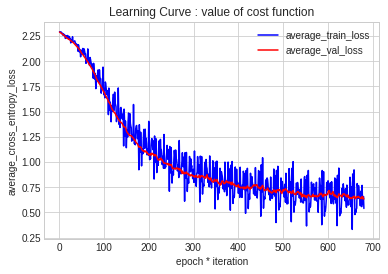

In [79]:
clf.show_learning_curve()

In [0]:
y_pred = clf.predict(X_val[:1000])

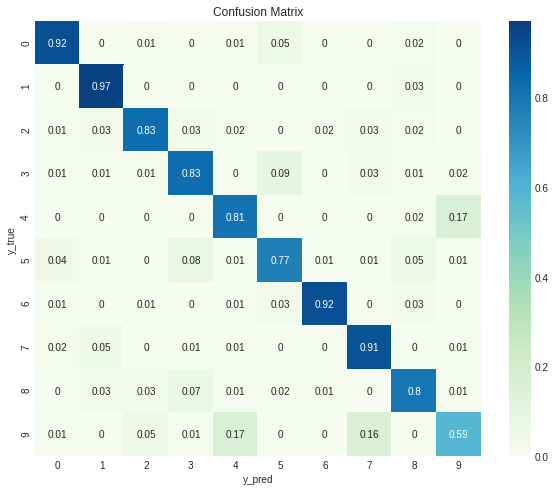

In [81]:
clf.show_accuracy(y_val[:1000], y_pred)

- １次元畳み込み層を用いた学習、推定が行われていることを確認した。

### Take away

畳み込み層を用いたニューラルネットワークについては、以下の点に注意しながら構築する必要がある。

1. 出力（output）の形状を理解すること。具体的には（サンプル数、フィルタ枚数、特徴量）となる。
    - 畳み込む範囲を具体的にイメージする。（入力値、フィルタサイズ、ストライドの具体例を用いて関係性を理解する）
    - 出力値の形状を確認した上で出力値を零行列で初期化しておき、畳み込みの計算結果を逐次的に代入すると混乱が生じにくい。

2. 畳み込み層の次の層のノード数は、畳み込み層の出力の特徴量と揃える必要がある。